# Outline

- Part 1: Load geographical data
- Part 2: Load income data
- Part 3: Pull Foursquare venue data
- Part 4: Process and cluster venue data
- Part 5: Correlate clusters with income and analyze
- Part 6: Build regression models

In [5]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re, json
import requests
from bs4 import BeautifulSoup
from pandas import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

import geopy.geocoders
from geopy.geocoders import ArcGIS
geopy.geocoders.options.default_timeout = None

import folium

from sklearn.cluster import KMeans

# Part 1

In [1]:
with open('data/nyu.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

In [2]:
with open('data/brooklyn.json') as json_data:
    brooklyn_data = json.load(json_data)

In [3]:
def assemble_dataset():
    column_names = ['Neighborhood', 'Latitude', 'Longitude'] 
    neighborhoods = pd.DataFrame(columns=column_names)

    for data in neighborhoods_data:
        borough = neighborhood_name = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']

        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        if borough != 'Brooklyn': continue

        neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)
    return neighborhoods

In [6]:
brooklyn = assemble_dataset()
brooklyn.head()

,Neighborhood,Latitude,Longitude
0,Bay Ridge,40.625801,-74.030621
1,Bensonhurst,40.611009,-73.995180
2,Sunset Park,40.645103,-74.010316
3,Greenpoint,40.730201,-73.954241
4,Gravesend,40.595260,-73.973471


In [7]:
address = 'Brooklyn, NY'

geolocator = ArcGIS()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.692450000000065, -73.99035999999995.


In [122]:
map_brooklyn = folium.Map(location=[latitude-4.4e-2, longitude+4e-2], zoom_start=11.5) # Corrections added to better center the map

for lat, lng, label in zip(brooklyn['Latitude'], brooklyn['Longitude'], brooklyn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_brooklyn)  

folium.GeoJson(
    brooklyn_data,
    name='geojson'
).add_to(map_brooklyn)
    
map_brooklyn

# Part 2

In [35]:
brooklyn_income = pd.read_csv('data/income.csv')
brooklyn_income.drop(["Borough"], 1, inplace=True)
brooklyn_income.head()

,Neighborhood,Income
0,Bath Beach,53198
1,Bay Ridge,67986
2,Bedford-Stuyvesant,47706
3,Bensonhurst,53198
4,Bergen Beach,74840


In [123]:
m = folium.Map(
    location=[latitude-4.4e-2, longitude+4e-2],
    zoom_start=12  # Limited levels of zoom for free Mapbox tiles.
)

folium.Choropleth(
    geo_data=brooklyn_data,
    name='choropleth',
    data=brooklyn_income,
    columns=['Neighborhood', 'Income'],
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Household Income'
).add_to(m)

for lat, lng, label in zip(brooklyn['Latitude'], brooklyn['Longitude'], brooklyn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#ffffff',
        fill_opacity=0,
        parse_html=False).add_to(m)  

folium.LayerControl().add_to(m)

m

# Part 3

In [44]:
CLIENT_ID = '34D1YPS0PXJOOPO3REYJDXPPTCOUYHCO53L55FDUEACHMDIX'
CLIENT_SECRET = 'Z2L254FJLXQAMSGZQ3NKDEYAMFUZDZGOZFDHQRUAN3Z1VK30'
VERSION = '20200321'

RADIUS, LIMIT = 500, 200

In [47]:
def get_nearby_venues(names, latitudes, longitudes, radius=RADIUS, limit=LIMIT):
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            limit)
        
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except:
            continue
        
        venues_list.append([(
            name,
            lat,
            lng,
            venue['venue']['name'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories'][0]['name']) for venue in results
        ])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood',
        'Neighborhood Latitude',
        'Neighborhood Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longitude',
        'Venue Category'
    ]
    
    return nearby_venues

In [48]:
brooklyn_venues = get_nearby_venues(brooklyn['Neighborhood'], 
                                    brooklyn['Latitude'], 
                                    brooklyn['Longitude'])

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [56]:
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,44,44,44,44,44,44
Bay Ridge,86,86,86,86,86,86
Bedford Stuyvesant,29,29,29,29,29,29
Bensonhurst,30,30,30,30,30,30
Bergen Beach,7,7,7,7,7,7
Boerum Hill,92,92,92,92,92,92
Borough Park,20,20,20,20,20,20
Brighton Beach,45,45,45,45,45,45
Broadway Junction,21,21,21,21,21,21


Drop all columns with fewer than 10 venues

In [67]:
drop_hoods = brooklyn_venues.groupby('Neighborhood').count().\
                loc[brooklyn_venues.groupby('Neighborhood').count()['Venue'] < 10].index.to_list()
drop_hoods

['Bergen Beach',
 'Canarsie',
 'Dyker Heights',
 'Mill Island',
 'Paerdegat Basin',
 'Sea Gate']

In [74]:
drop_rows = brooklyn_venues[brooklyn_venues['Neighborhood'].isin(drop_hoods)].index
brooklyn_venues.drop(drop_rows, inplace=True)
brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


In [76]:
drop_rows = brooklyn[brooklyn['Neighborhood'].isin(drop_hoods)].index
brooklyn.drop(drop_rows, inplace=True)
brooklyn.head()

,Neighborhood,Latitude,Longitude
0,Bay Ridge,40.625801,-74.030621
1,Bensonhurst,40.611009,-73.995180
2,Sunset Park,40.645103,-74.010316
3,Greenpoint,40.730201,-73.954241
4,Gravesend,40.595260,-73.973471


In [77]:
print(brooklyn.shape)
print(brooklyn_venues.shape)

(64, 3)
(2765, 7)


# Part 4

In [104]:
def get_most_common(venues):
    '''
    Turn a venues dataset into a dataset showing the top 10 venues in each neighborhood.
    '''
    
    onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
    onehot.insert(0, 'Neighborhoods', venues['Neighborhood'].to_list(), True)
    grouped = onehot.groupby('Neighborhoods').mean().reset_index()
    
    neighborhoods = pd.DataFrame(columns=[
        'Neighborhood',
        'Top 1st',
        'Top 2nd',
        'Top 3rd',
        'Top 4th',
        'Top 5th',
        'Top 6th',
        'Top 7th',
        'Top 8th',
        'Top 9th',
        'Top 10th'
    ])
    
    neighborhoods['Neighborhood'] = grouped['Neighborhoods']
    
    for idx in range(grouped.shape[0]):
        neighborhoods.iloc[idx, 1:] = grouped.iloc[idx, 1:].sort_values(ascending=False).index.values[:10]
    
    return grouped, neighborhoods


In [105]:
brooklyn_grouped, brooklyn_common = get_most_common(brooklyn_venues)
print(brooklyn_grouped.shape)
print(brooklyn_common.shape)
brooklyn_common.head()

(64, 289)
(64, 11)


,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
0,Bath Beach,Pharmacy,Chinese Restaurant,Sushi Restaurant,Gas Station,Pizza Place,Bubble Tea Shop,Italian Restaurant,Fast Food Restaurant,Sandwich Place,Surf Spot
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Bar,Ice Cream Shop,Bagel Shop,Sandwich Place,Chinese Restaurant
2,Bedford Stuyvesant,Bar,Café,Pizza Place,Deli / Bodega,Coffee Shop,Bus Stop,Bus Station,Boutique,BBQ Joint,Gift Shop
3,Bensonhurst,Pizza Place,Chinese Restaurant,Italian Restaurant,Donut Shop,Sushi Restaurant,Grocery Store,Ice Cream Shop,Cosmetics Shop,Bagel Shop,American Restaurant
4,Boerum Hill,Dance Studio,Coffee Shop,Bar,French Restaurant,Sandwich Place,Arts & Crafts Store,Bakery,Furniture / Home Store,Yoga Studio,Boutique


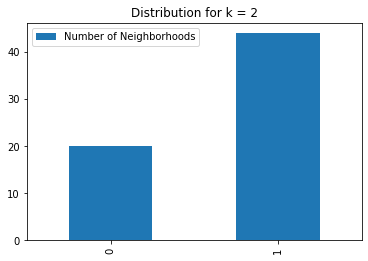

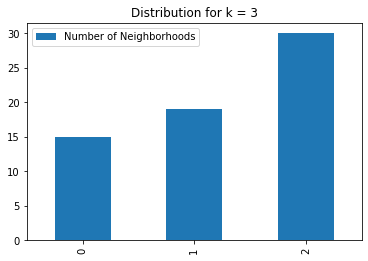

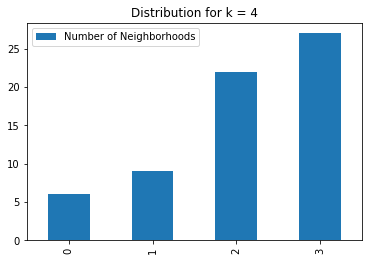

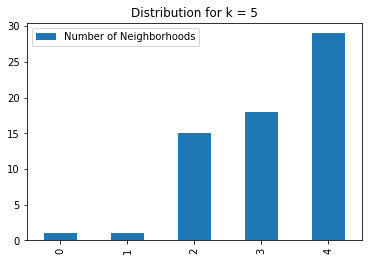

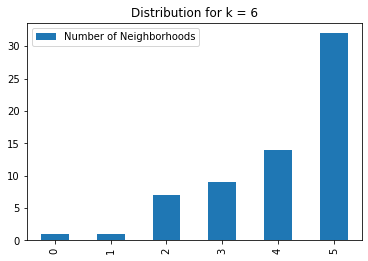

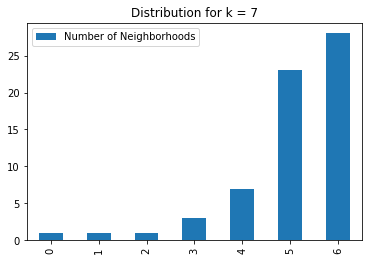

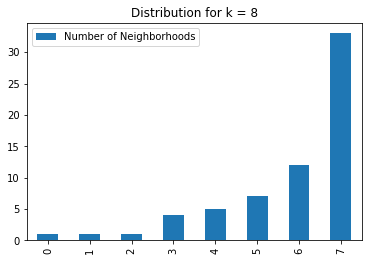

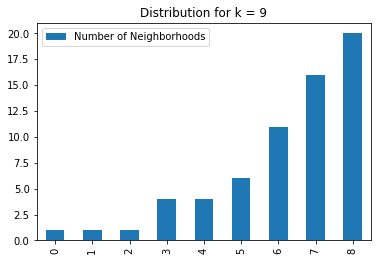

In [106]:
brooklyn_clusters = brooklyn_grouped.drop('Neighborhoods', 1)

for k in range(2, 10):
    kmeans_test = KMeans(n_clusters=k, random_state=0).fit(brooklyn_clusters)
    dft = pd.DataFrame(np.sort(np.unique(kmeans_test.labels_, return_counts=True)[1]), columns=['Number of Neighborhoods']).plot(kind='bar')
    plt.title(f'Distribution for k = {k}')
    plt.show()

In [190]:
kmeans = KMeans(4, random_state=0).fit(brooklyn_clusters)

brooklyn_common.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))
brooklyn_merged = brooklyn
brooklyn_merged = brooklyn_merged.join(brooklyn_common.set_index('Neighborhood'), on='Neighborhood')

ValueError: cannot insert Cluster Labels, already exists

# Part 5

In [191]:
n_clusters = 4
map_clusters = folium.Map(
    location=[latitude-4.4e-2, longitude+4e-2],
    zoom_start=12  # Limited levels of zoom for free Mapbox tiles.
)

folium.Choropleth(
    geo_data=brooklyn_data,
    name='choropleth',
    data=brooklyn_income,
    columns=['Neighborhoods', 'Income'],
    key_on='feature.properties.name',
    fill_color='Greens',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Household Income'
).add_to(map_clusters)

x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)

map_clusters

## Cluster 1

In [120]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
3,Greenpoint,Bar,Coffee Shop,Pizza Place,Cocktail Bar,Mexican Restaurant,French Restaurant,Café,Boutique,Yoga Studio,Sushi Restaurant
12,Windsor Terrace,Diner,Deli / Bodega,Grocery Store,Plaza,Park,Café,Italian Restaurant,Sushi Restaurant,Beer Store,Bookstore
13,Prospect Heights,Bar,Bakery,Thai Restaurant,Wine Shop,Café,Cocktail Bar,Gourmet Shop,Mexican Restaurant,Yoga Studio,American Restaurant
15,Williamsburg,Bar,Coffee Shop,Pizza Place,Bagel Shop,Yoga Studio,Food Truck,Taco Place,Latin American Restaurant,Steakhouse,Liquor Store
16,Bushwick,Bar,Coffee Shop,Mexican Restaurant,Pizza Place,Deli / Bodega,Discount Store,Bakery,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Korean Restaurant
17,Bedford Stuyvesant,Bar,Café,Pizza Place,Deli / Bodega,Coffee Shop,Bus Stop,Bus Station,Boutique,BBQ Joint,Gift Shop
18,Brooklyn Heights,Yoga Studio,Park,Deli / Bodega,Cosmetics Shop,Pizza Place,Italian Restaurant,Gym,Bakery,Coffee Shop,Bar
19,Cobble Hill,Playground,Bar,Coffee Shop,Pizza Place,Yoga Studio,Cocktail Bar,Deli / Bodega,Italian Restaurant,Ice Cream Shop,Wine Shop
20,Carroll Gardens,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Bakery,Gym / Fitness Center,Wine Shop,Spa,Bar,Thai Restaurant
21,Red Hook,Seafood Restaurant,Park,American Restaurant,Art Gallery,Bar,Ice Cream Shop,Flower Shop,Wine Shop,Café,Pizza Place


## Cluster 2

In [119]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
0,Bay Ridge,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Bar,Ice Cream Shop,Bagel Shop,Sandwich Place,Chinese Restaurant
1,Bensonhurst,Pizza Place,Chinese Restaurant,Italian Restaurant,Donut Shop,Sushi Restaurant,Grocery Store,Ice Cream Shop,Cosmetics Shop,Bagel Shop,American Restaurant
4,Gravesend,Italian Restaurant,Pizza Place,Bakery,Lounge,Martial Arts Dojo,Bus Station,Bar,Liquor Store,Furniture / Home Store,Men's Store
5,Brighton Beach,Beach,Russian Restaurant,Restaurant,Eastern European Restaurant,Gourmet Shop,Neighborhood,Sushi Restaurant,Mobile Phone Shop,Bank,Pharmacy
6,Sheepshead Bay,Dessert Shop,Turkish Restaurant,Sandwich Place,Boat or Ferry,Café,Russian Restaurant,Restaurant,Playground,Pizza Place,Yoga Studio
7,Manhattan Terrace,Ice Cream Shop,Pizza Place,Donut Shop,Coffee Shop,Mobile Phone Shop,Steakhouse,Organic Grocery,Grocery Store,Restaurant,Eastern European Restaurant
9,Crown Heights,Pizza Place,Café,Museum,Bagel Shop,Salon / Barbershop,Sushi Restaurant,Burger Joint,Electronics Store,Candy Store,Supermarket
11,Kensington,Thai Restaurant,Grocery Store,Ice Cream Shop,Sandwich Place,Pizza Place,Lingerie Store,Liquor Store,Spa,Deli / Bodega,Mexican Restaurant
14,Brownsville,Restaurant,Moving Target,Chinese Restaurant,Park,Pizza Place,Performing Arts Venue,Playground,Fried Chicken Joint,Farmers Market,Spanish Restaurant
31,Manhattan Beach,Bus Stop,Café,Ice Cream Shop,Harbor / Marina,Food,Beach,Sandwich Place,Playground,Pizza Place,Discount Store


## Cluster 3

In [118]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
8,Flatbush,Mexican Restaurant,Caribbean Restaurant,Coffee Shop,Chinese Restaurant,Lounge,Bank,Bagel Shop,Juice Bar,Donut Shop,Sandwich Place
10,East Flatbush,Food,Pharmacy,Caribbean Restaurant,Food & Drink Shop,Fast Food Restaurant,Park,Hardware Store,Supermarket,Moving Target,Print Shop
27,Starrett City,Pharmacy,Supermarket,Pizza Place,Caribbean Restaurant,American Restaurant,Convenience Store,Shopping Mall,Donut Shop,Yoga Studio,Field
29,Flatlands,Pharmacy,Fried Chicken Joint,Fast Food Restaurant,Caribbean Restaurant,Deli / Bodega,Park,Nightclub,Lounge,Electronics Store,Chinese Restaurant
32,Coney Island,Caribbean Restaurant,Baseball Stadium,Pizza Place,Clothing Store,Skating Rink,Music Venue,Farmers Market,Beach,Monument / Landmark,Theme Park Ride / Attraction
47,Prospect Park South,Caribbean Restaurant,Grocery Store,Pizza Place,Fast Food Restaurant,Mobile Phone Shop,Latin American Restaurant,Deli / Bodega,Donut Shop,Mexican Restaurant,Mattress Store
56,Rugby,Caribbean Restaurant,Bank,Grocery Store,Pizza Place,Diner,Seafood Restaurant,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Pharmacy
57,Remsen Village,Caribbean Restaurant,Fast Food Restaurant,Breakfast Spot,Donut Shop,Fried Chicken Joint,Fish Market,Supermarket,Sandwich Place,Auto Dealership,Salad Place
69,Erasmus,Caribbean Restaurant,Grocery Store,Chinese Restaurant,Yoga Studio,Pharmacy,Convenience Store,Donut Shop,Bus Line,Music Venue,Playground


## Cluster 4

In [121]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[0] + list(range(4, brooklyn_merged.shape[1]))]]

,Neighborhood,Top 1st,Top 2nd,Top 3rd,Top 4th,Top 5th,Top 6th,Top 7th,Top 8th,Top 9th,Top 10th
2,Sunset Park,Bank,Bakery,Pizza Place,Mexican Restaurant,Latin American Restaurant,Fried Chicken Joint,Mobile Phone Shop,Pharmacy,Gym,Grocery Store
25,Cypress Hills,Latin American Restaurant,Fried Chicken Joint,Ice Cream Shop,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Gas Station,Supermarket,Metro Station,Food
26,East New York,Deli / Bodega,Event Service,Fried Chicken Joint,Gym,Fast Food Restaurant,Bus Station,Caribbean Restaurant,Metro Station,Music Venue,Pizza Place
34,Borough Park,Bank,Pizza Place,Pharmacy,Coffee Shop,Café,Deli / Bodega,American Restaurant,Hotel,Chinese Restaurant,Grocery Store
46,Midwood,Pizza Place,Ice Cream Shop,Candy Store,Bakery,Bagel Shop,Convenience Store,Pharmacy,Video Game Store,Field,Falafel Restaurant
58,New Lots,Pizza Place,Grocery Store,Fried Chicken Joint,Plaza,Breakfast Spot,Chinese Restaurant,Bank,Metro Station,Asian Restaurant,Park


# Part 6

In [136]:
# Join place frequency and income datasets on valid keys for regression purposes

brooklyn_income.columns = ['Neighborhoods', 'Income']
brooklyn_regression = brooklyn_income.join(brooklyn_grouped.set_index('Neighborhoods'), on='Neighborhoods', how='inner')
brooklyn_regression.head()

,Neighborhoods,Income,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Laundry Service,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Sto

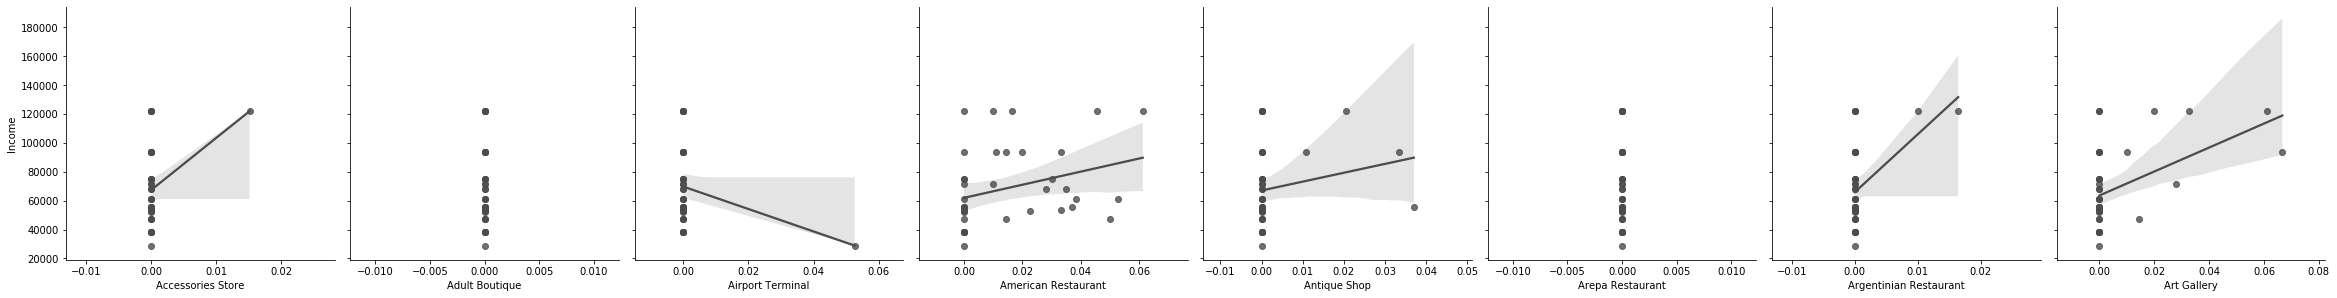

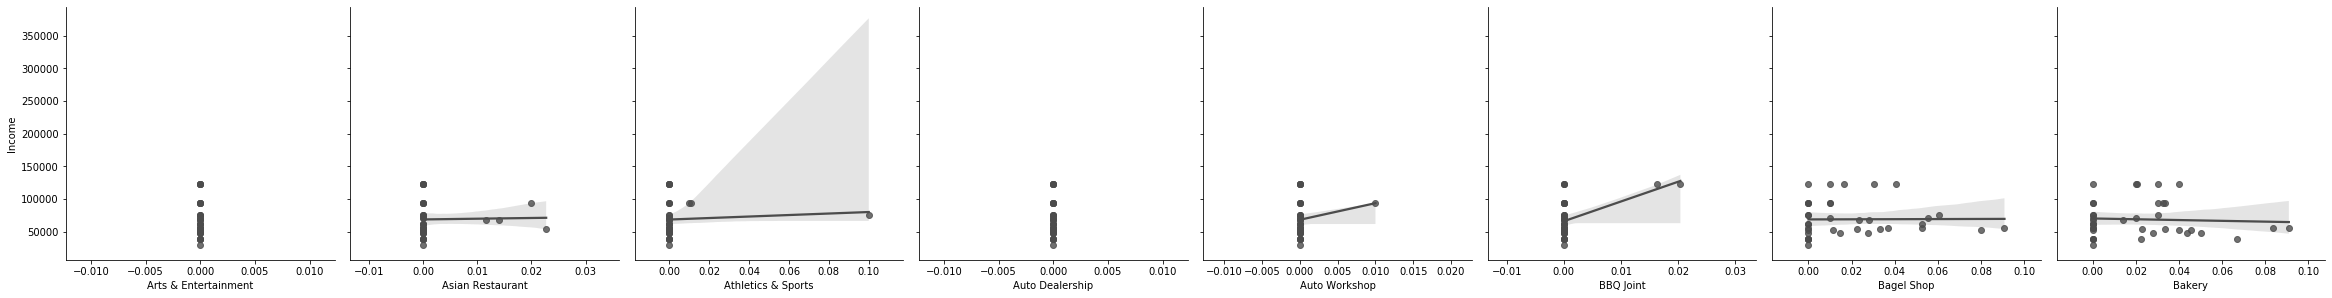

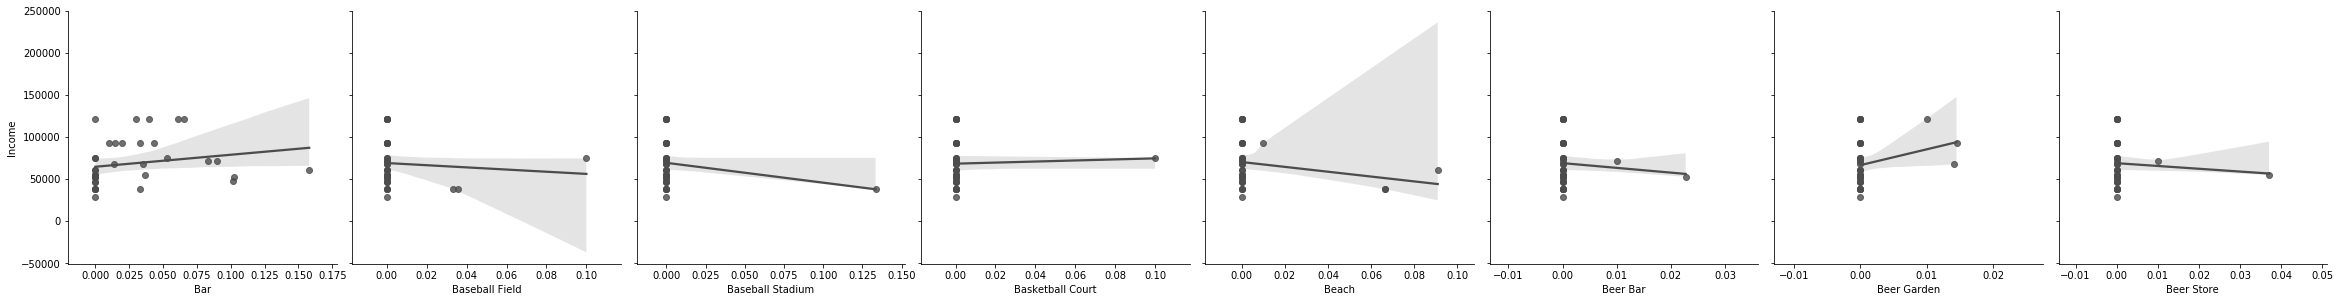

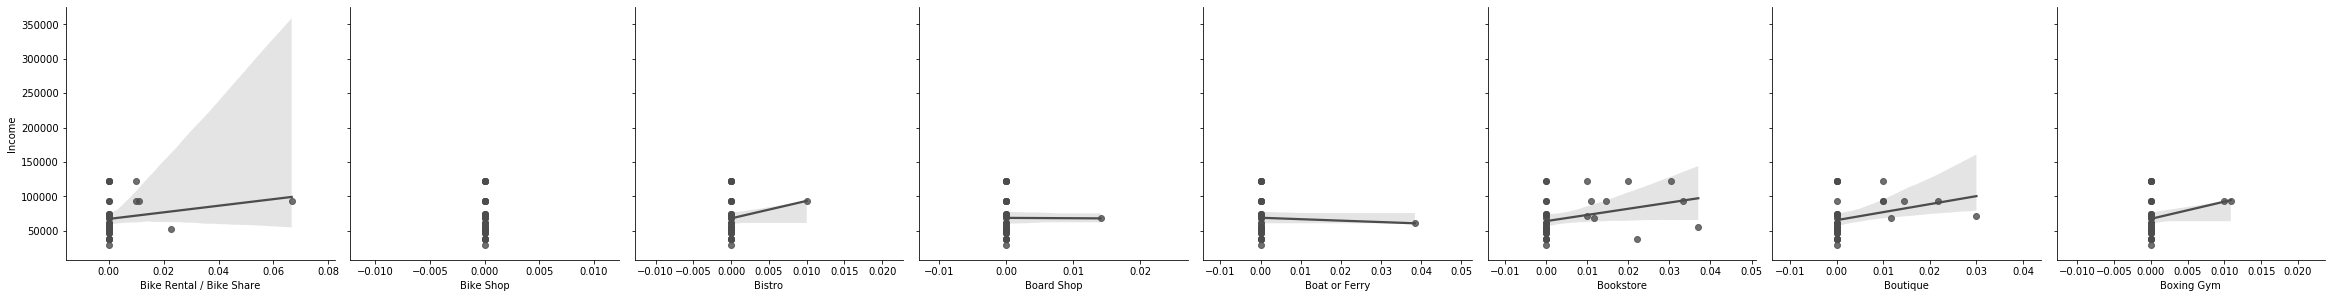

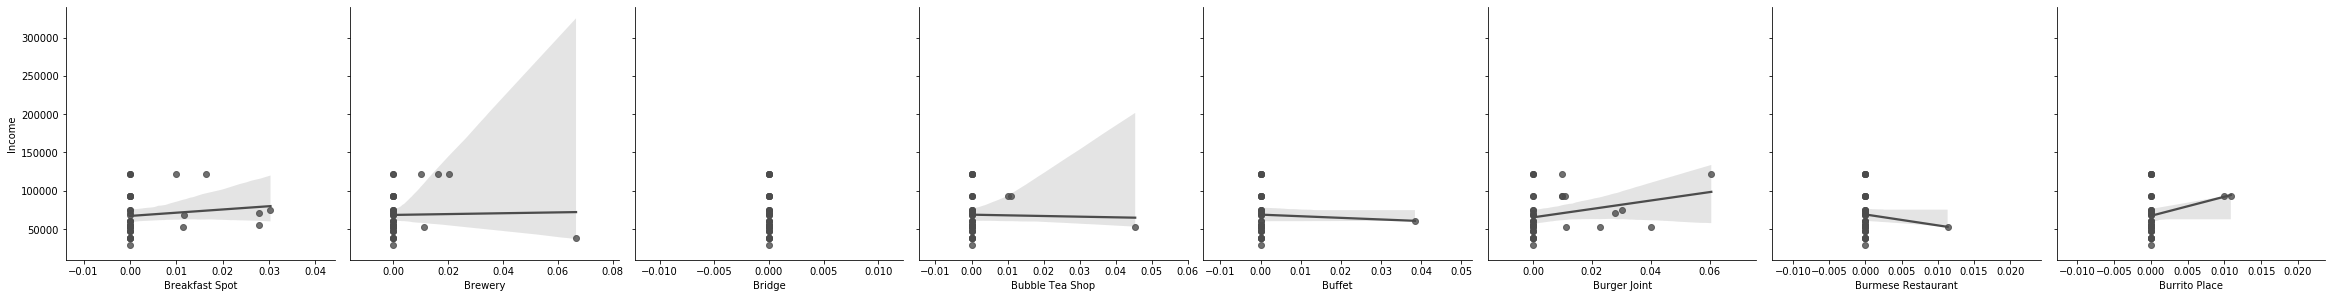

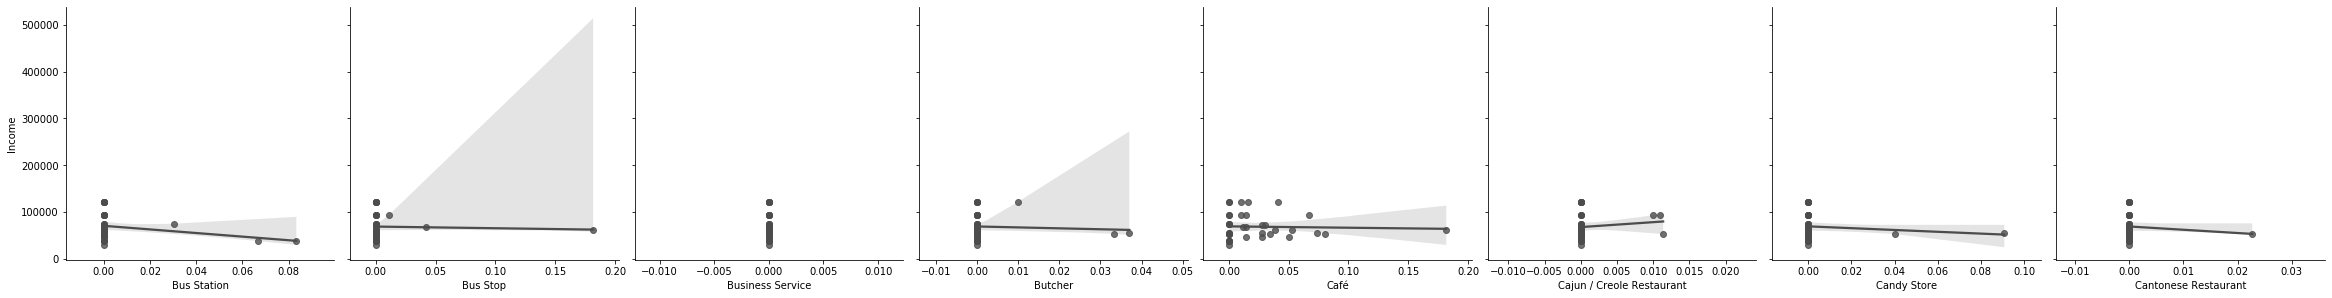

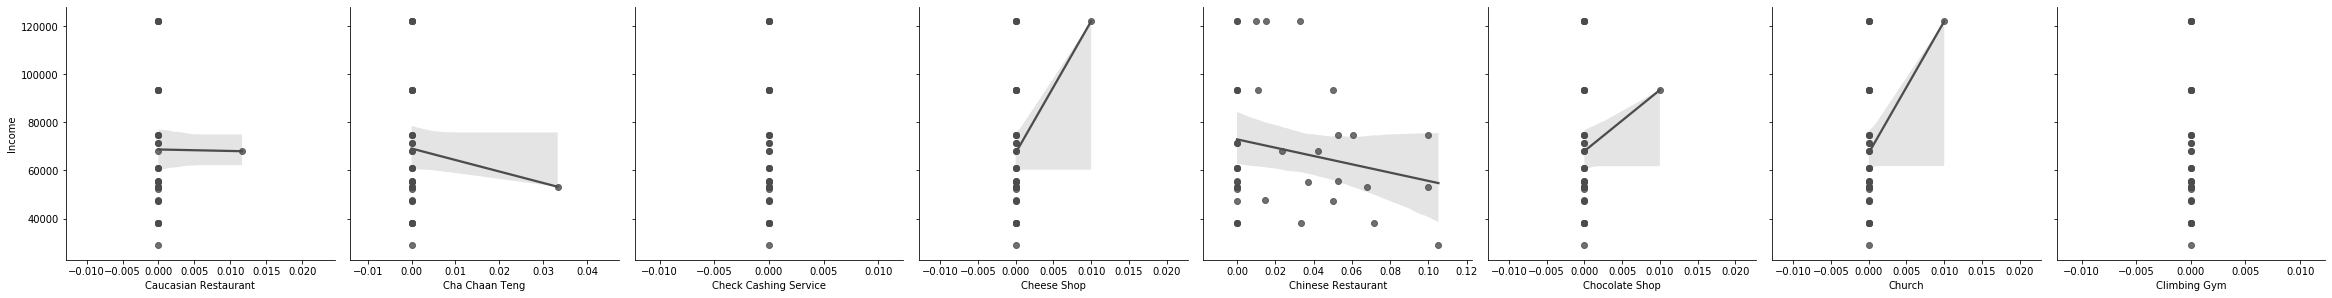

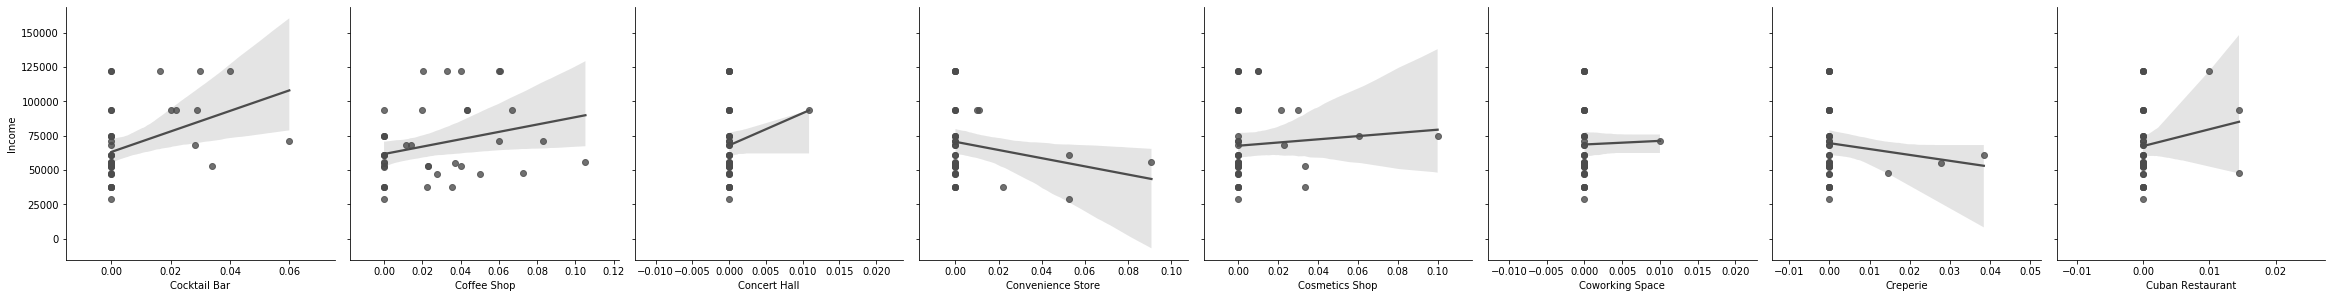

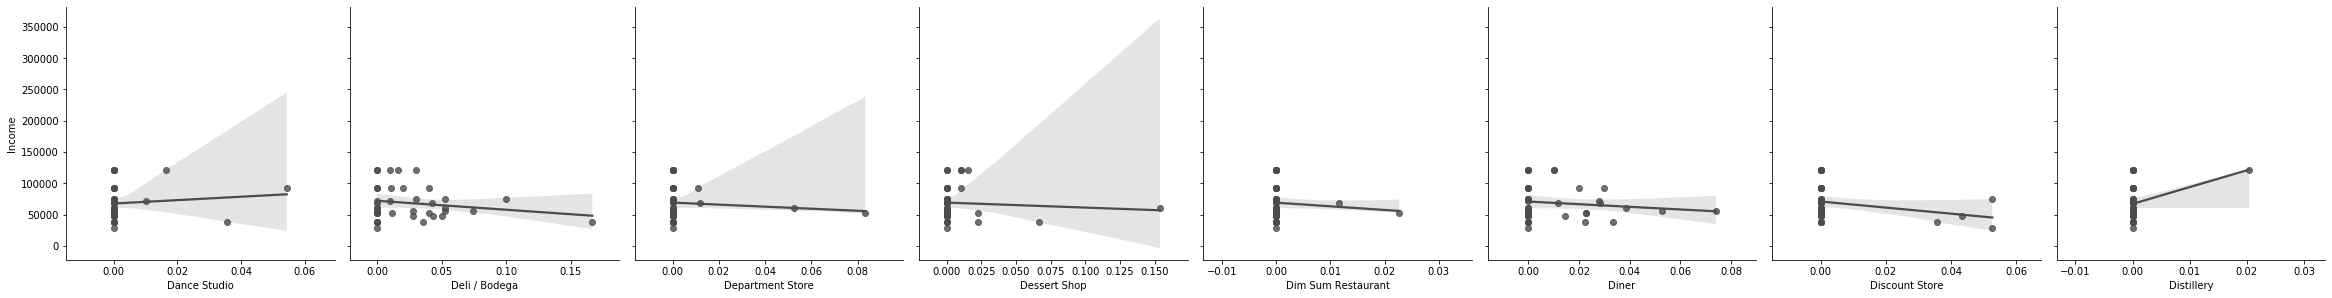

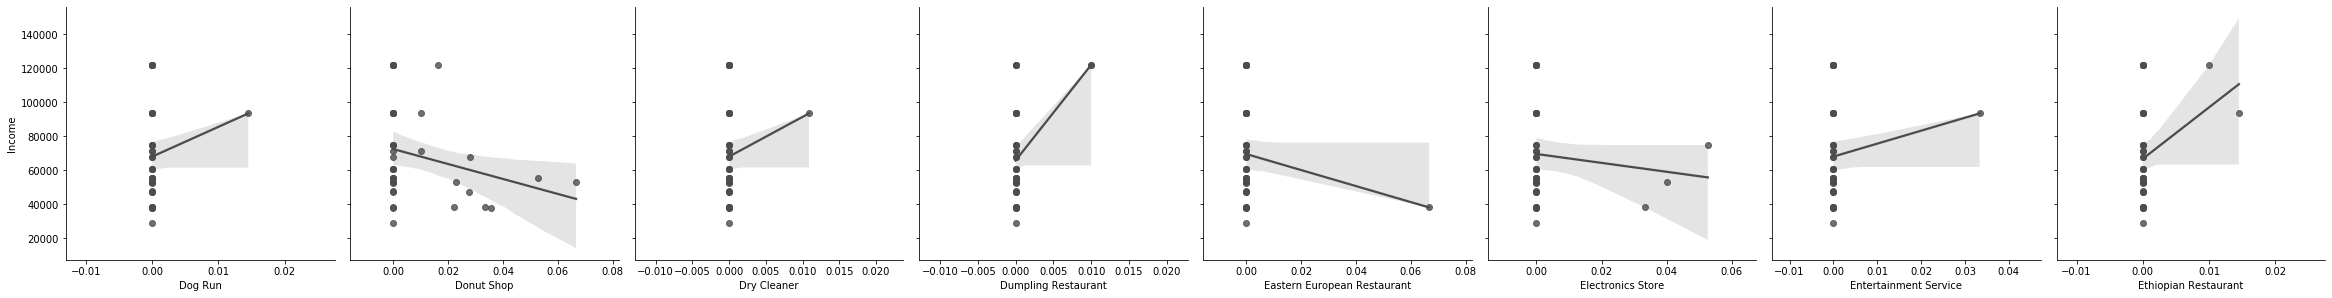

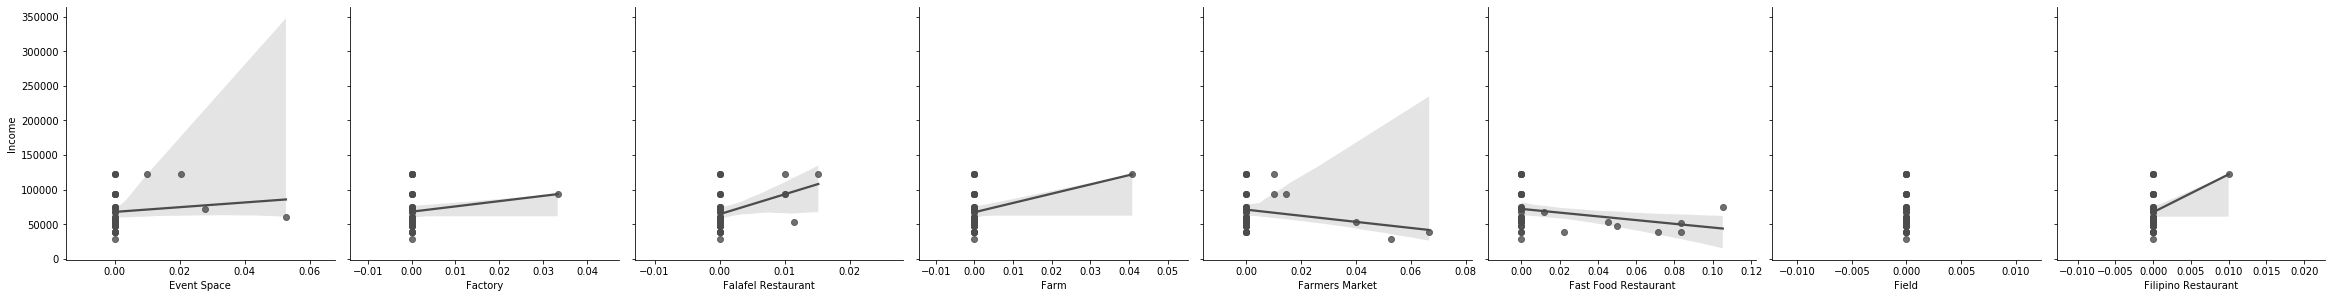

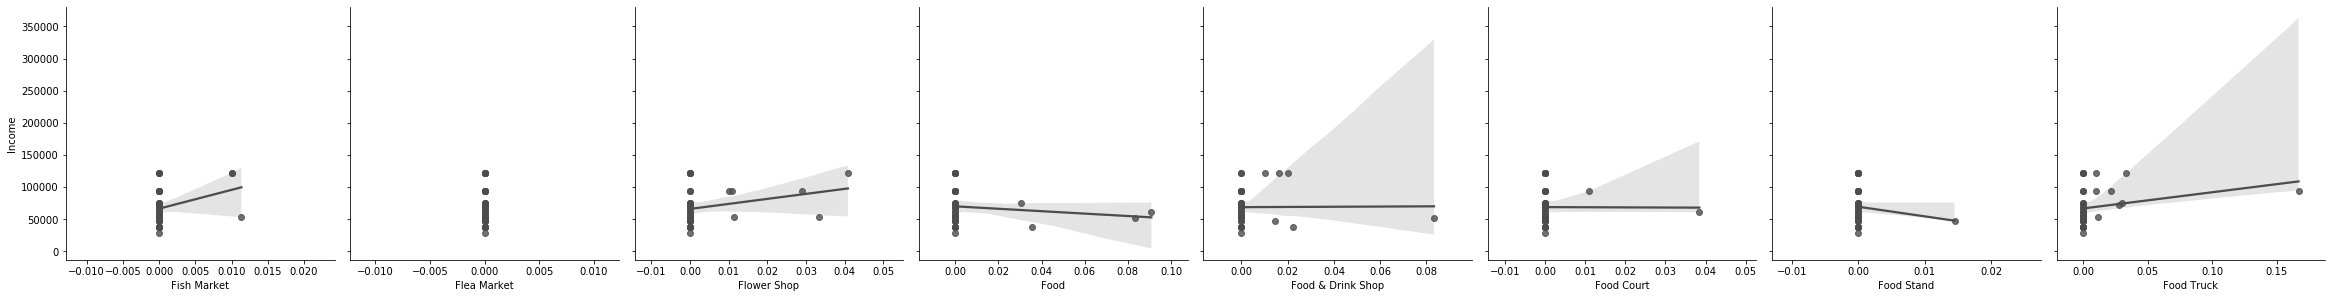

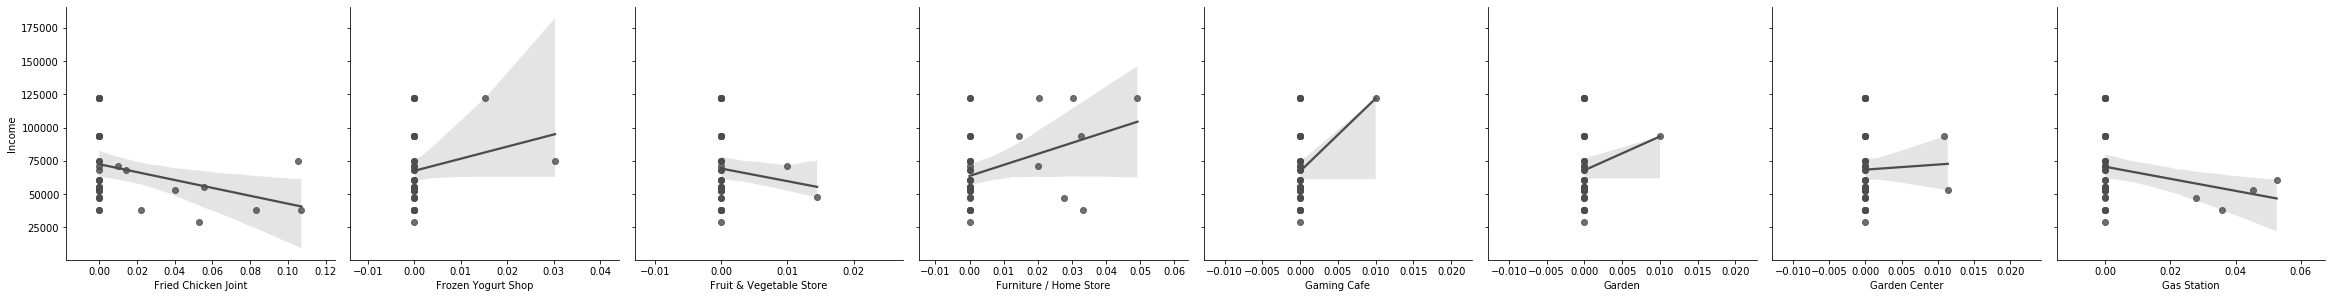

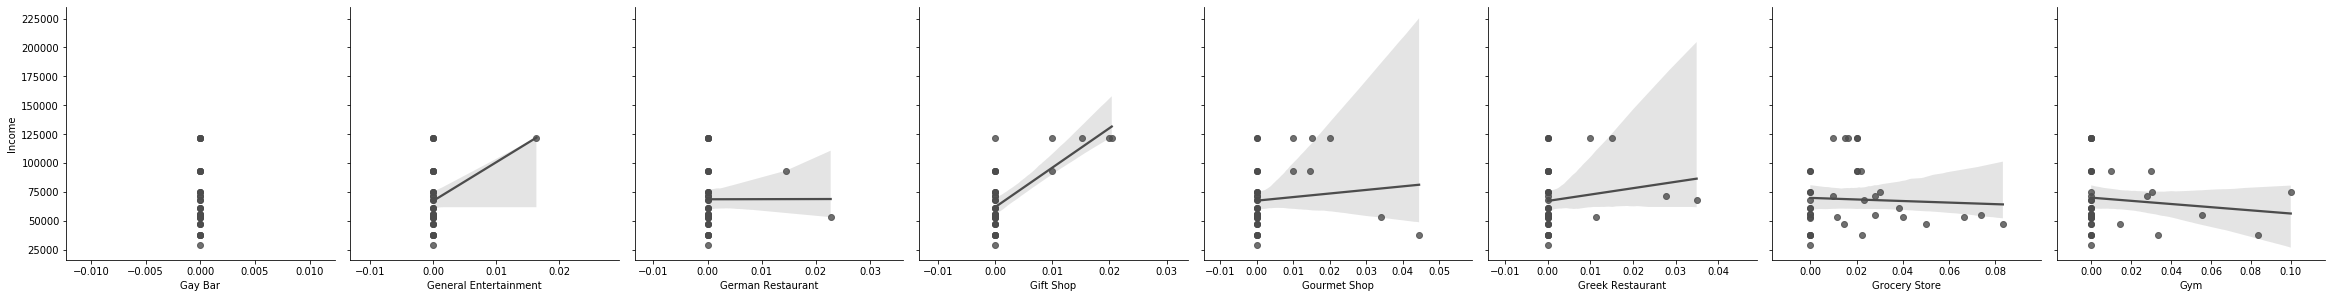

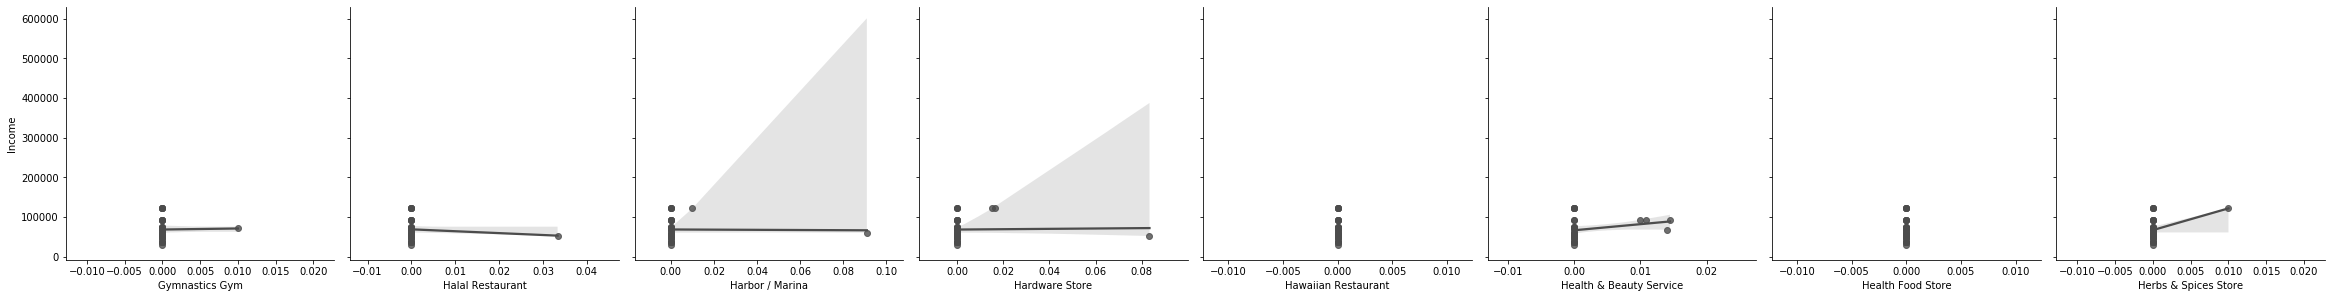

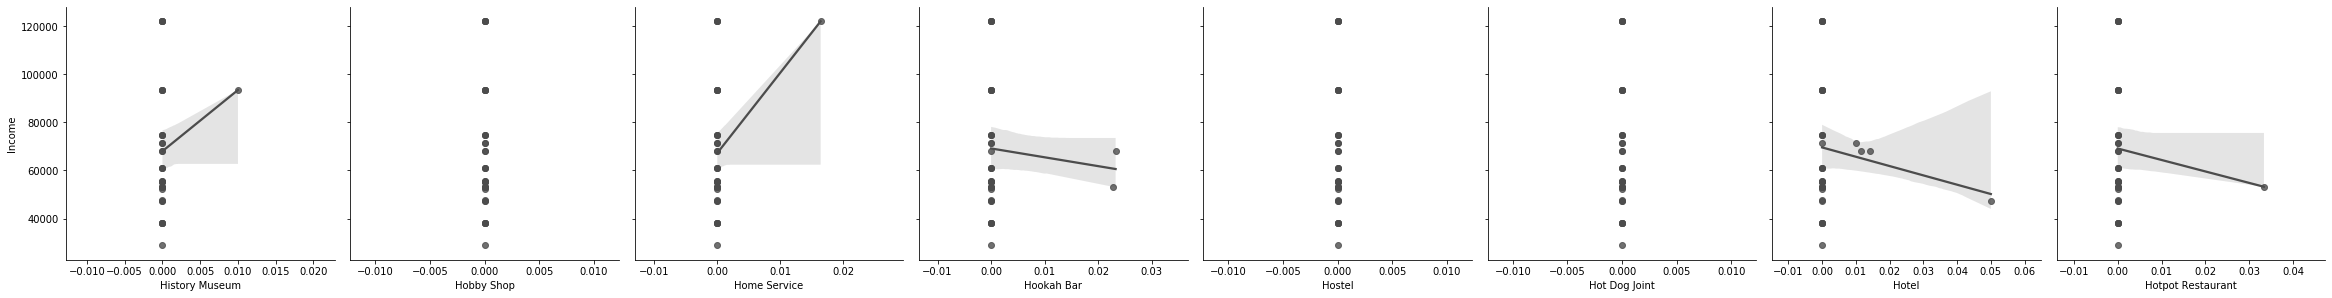

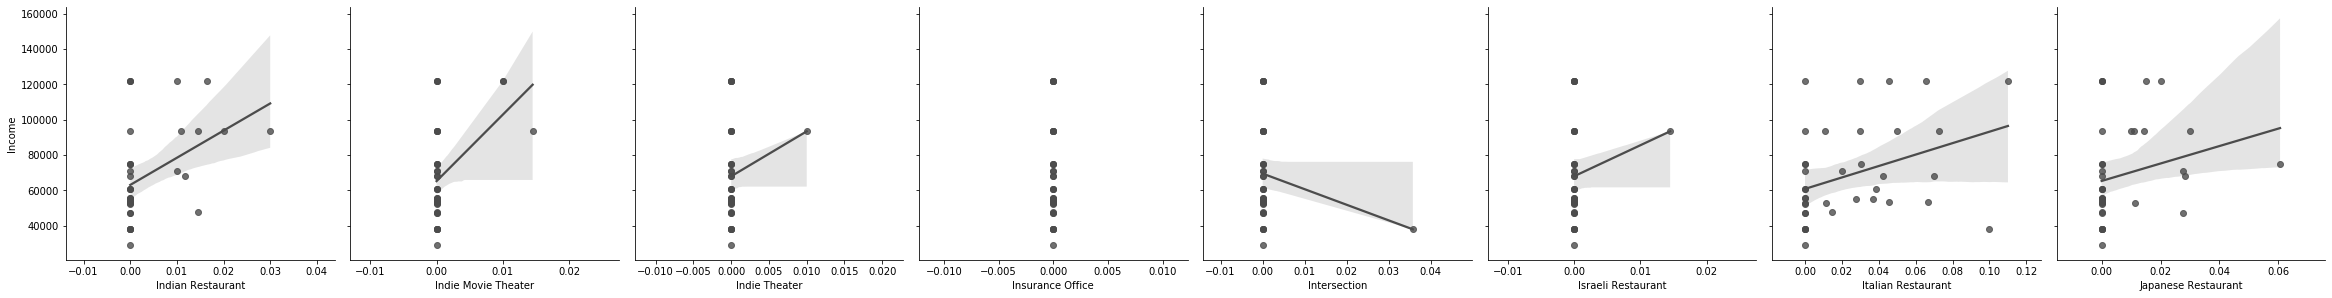

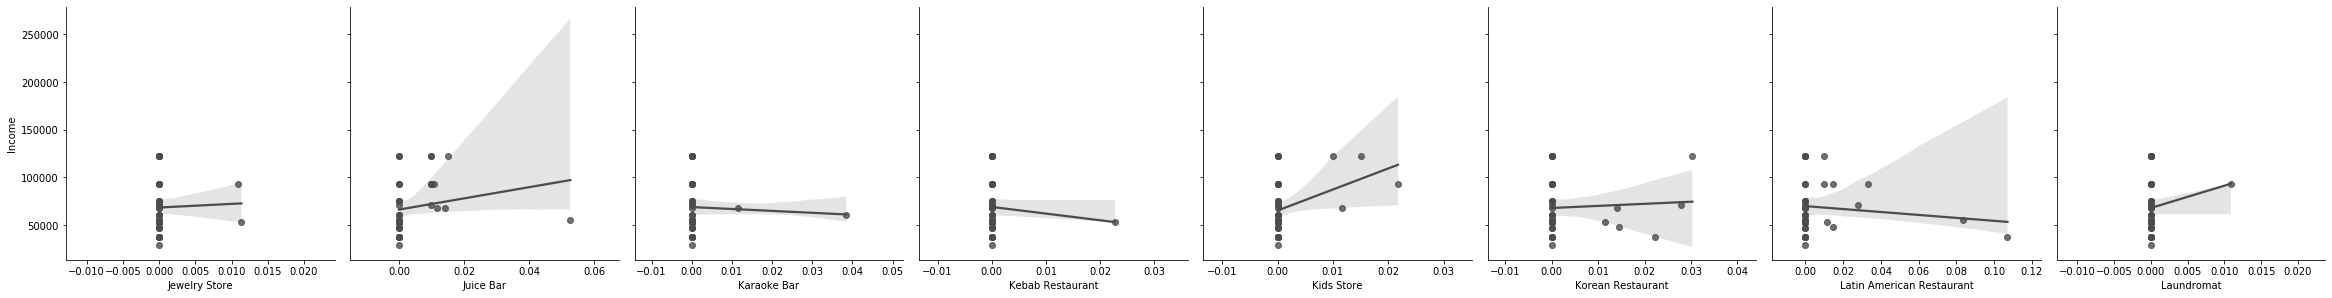

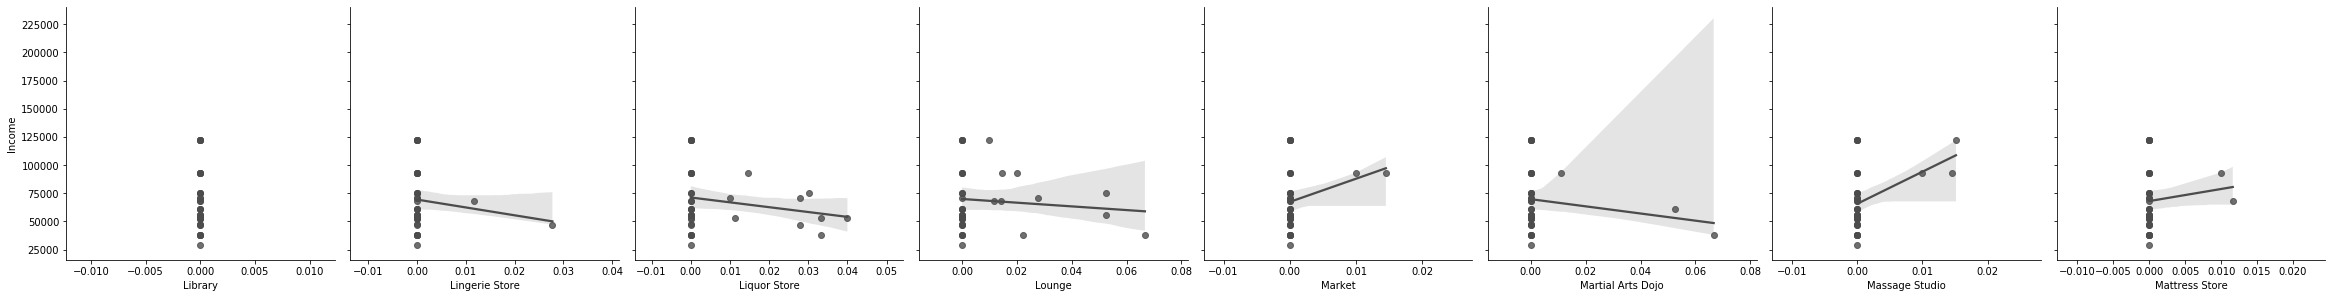

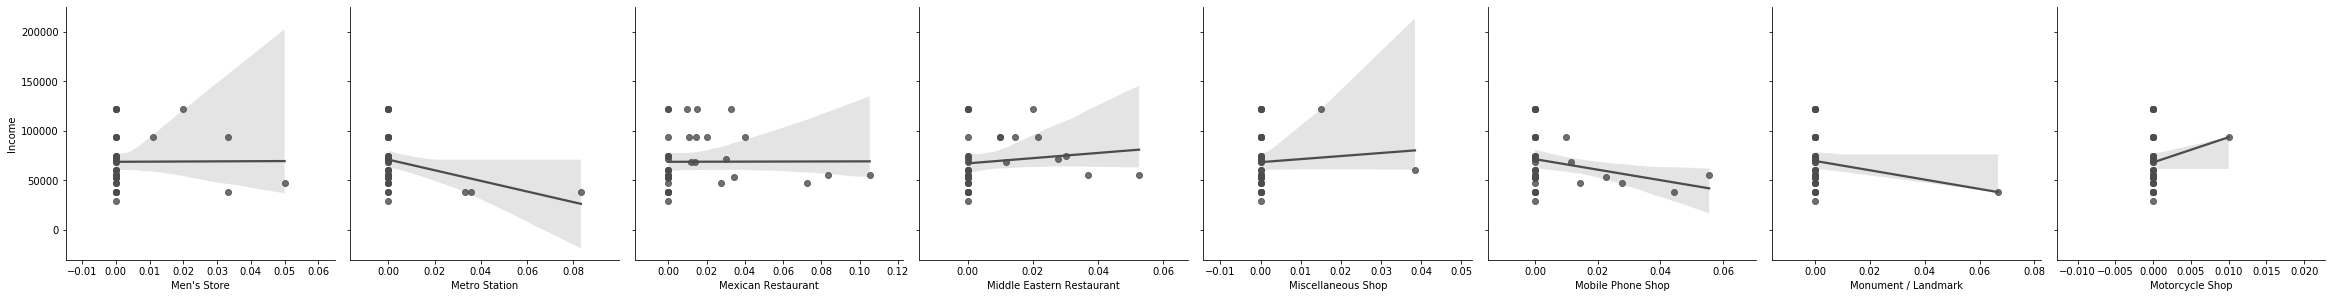

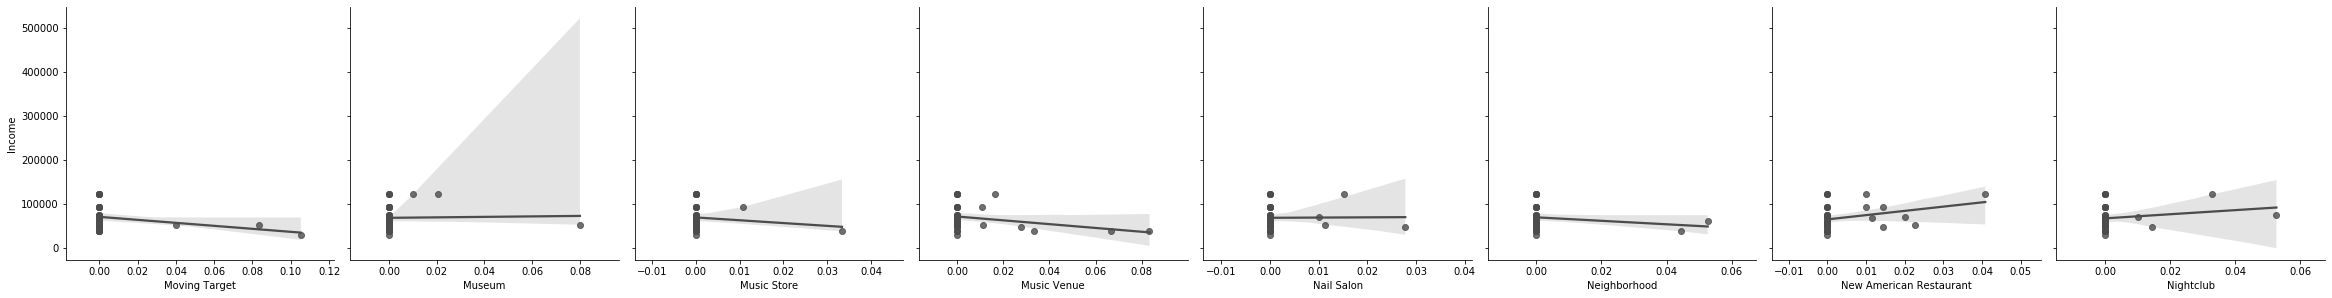

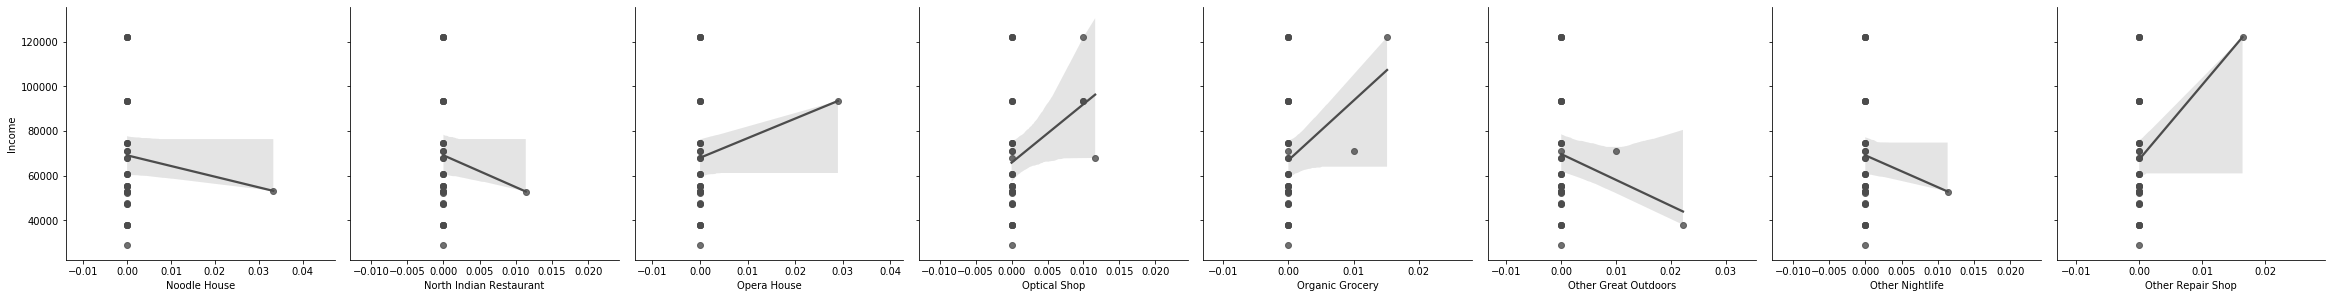

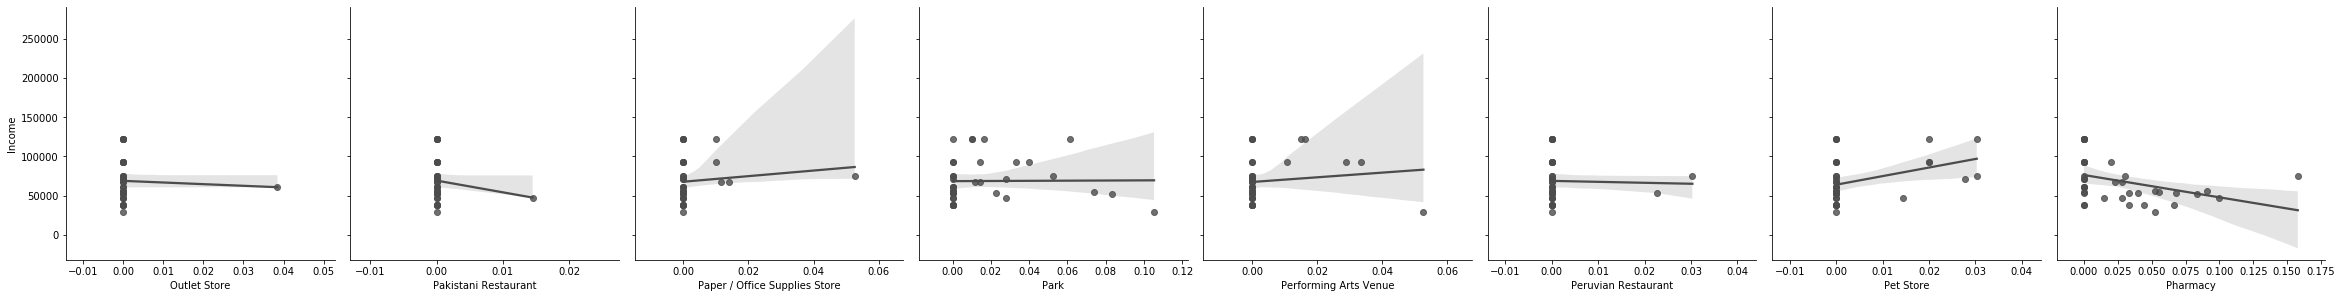

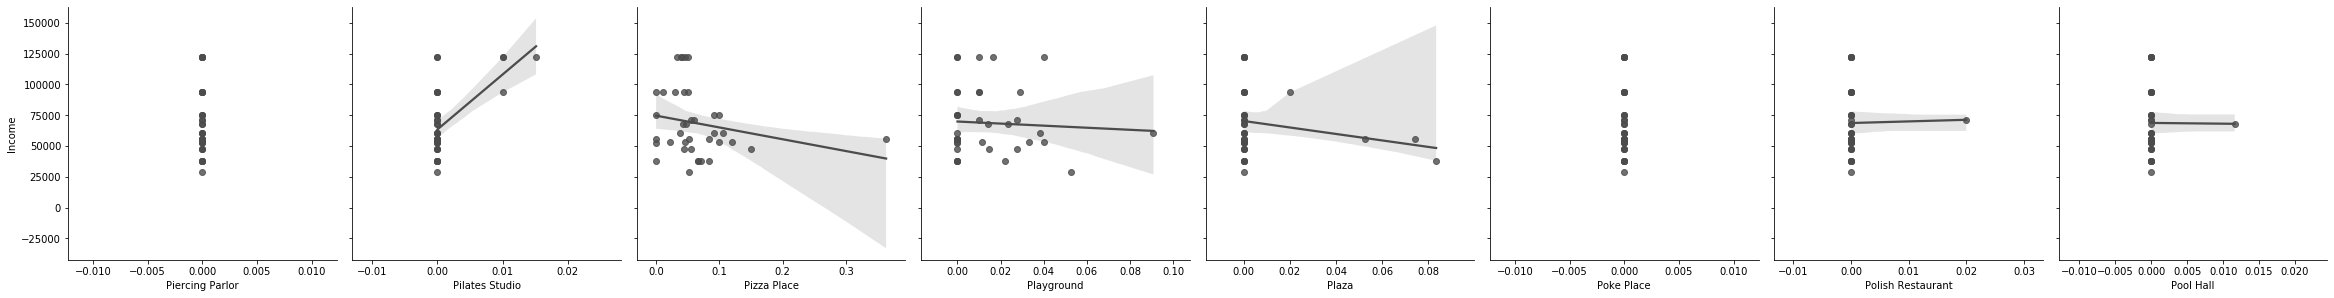

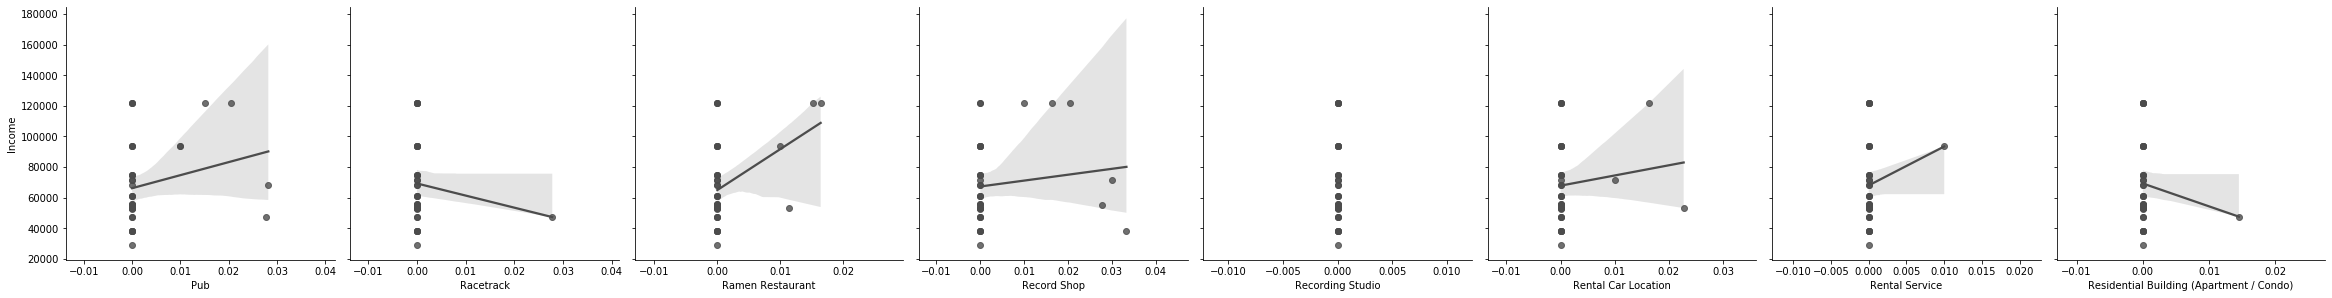

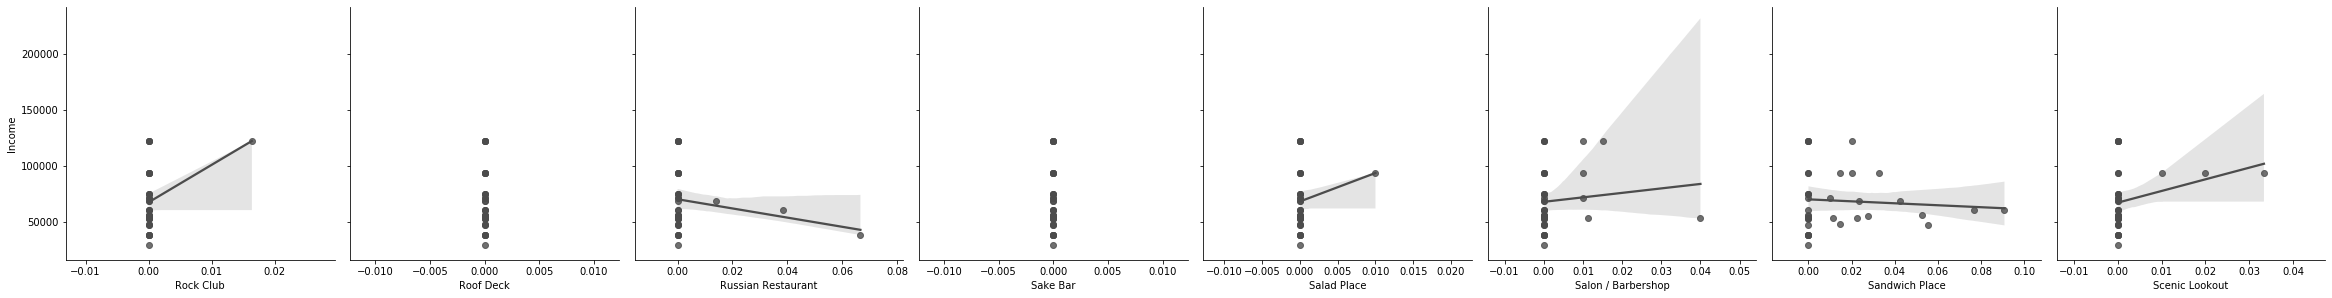

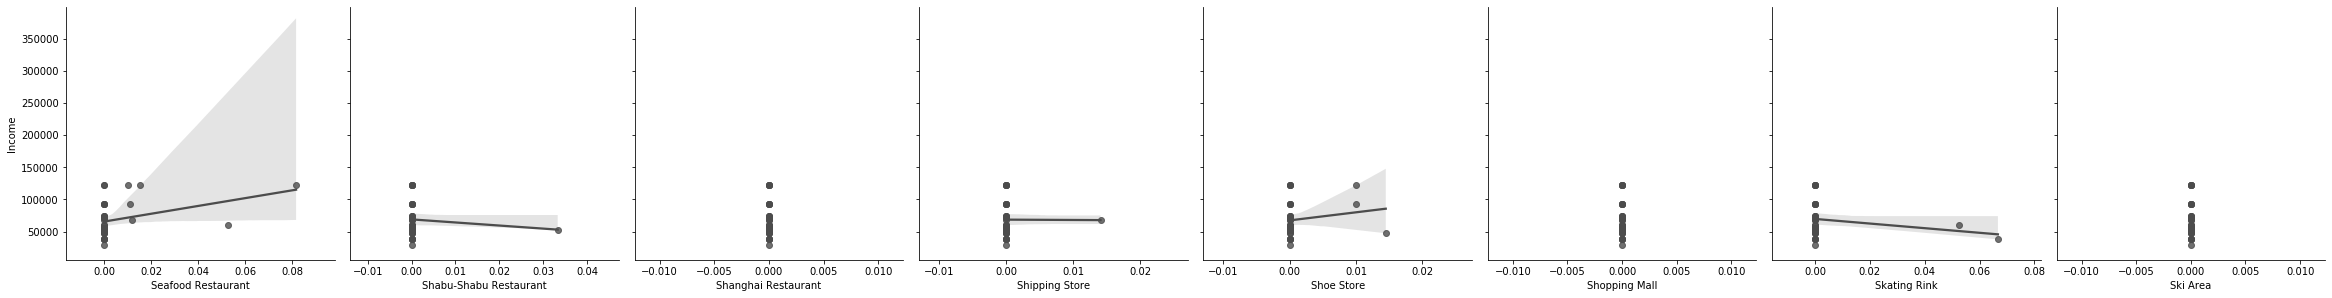

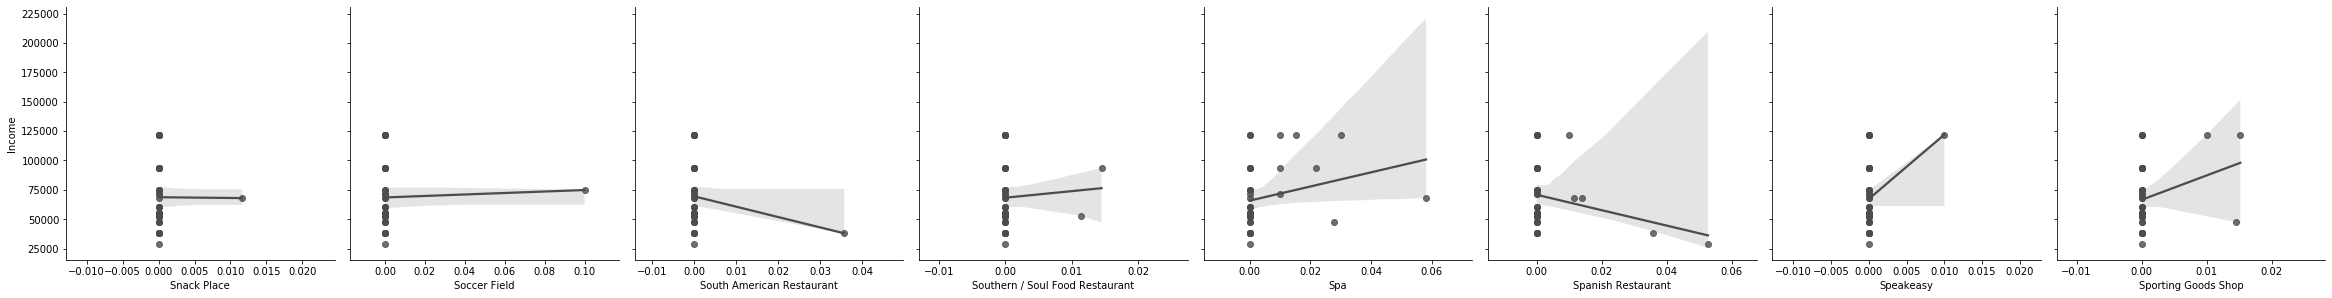

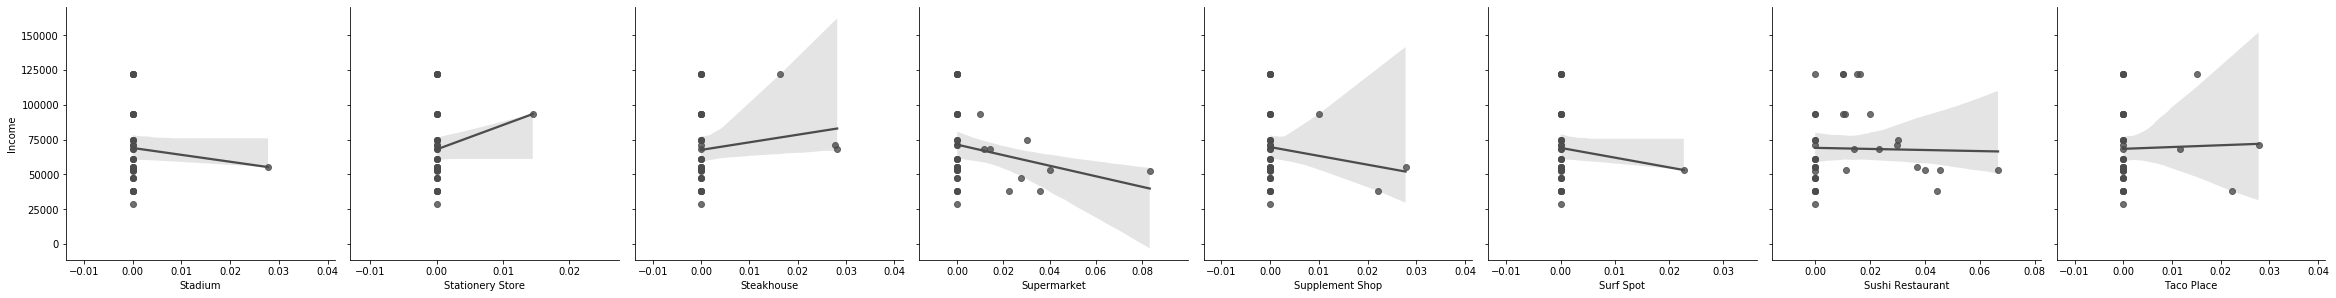

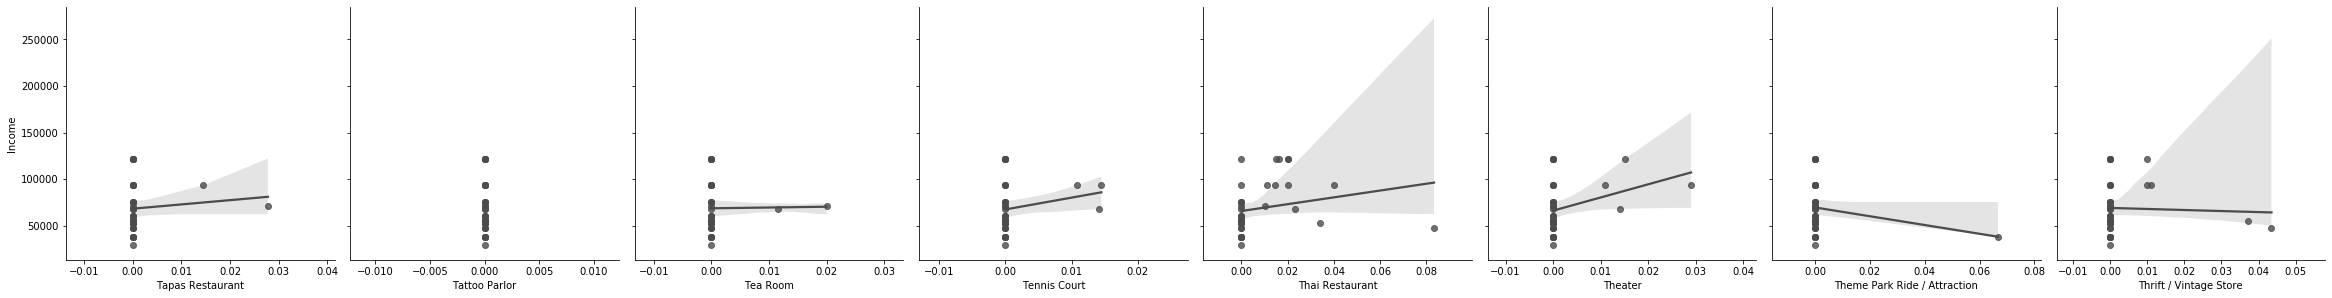

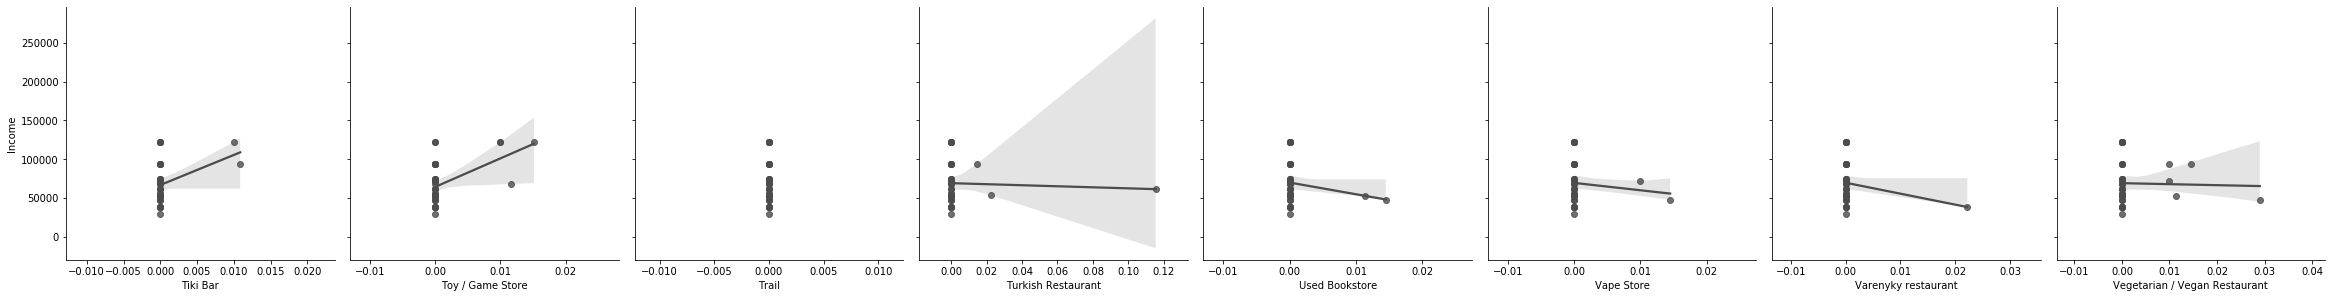

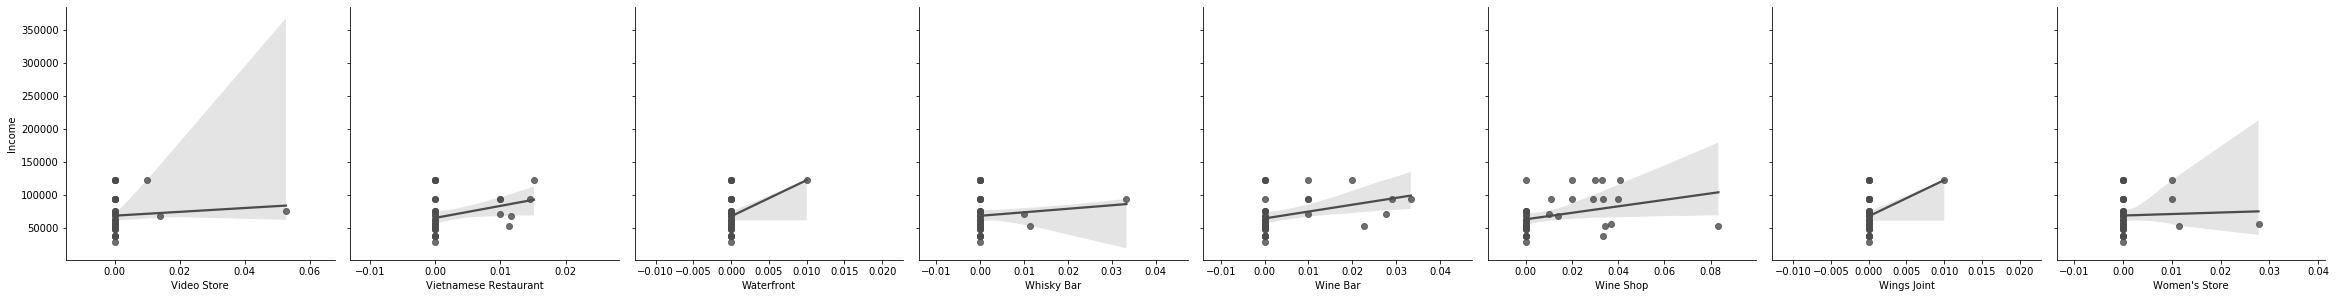

In [181]:
for s in range(2, 290, 9):
    g = sns.PairGrid(brooklyn_regression, y_vars=["Income"], x_vars=brooklyn_regression.columns[s:s+8].to_list(), height=4)
    g.map(sns.regplot, color=".3")
    plt.show()

In [152]:
top_venues = brooklyn_regression.sum(0)[2:].sort_values(ascending=False).index[:12].to_list()

In [153]:
top_venues

['Pizza Place',
 'Bar',
 'Pharmacy',
 'Coffee Shop',
 'Deli / Bodega',
 'Chinese Restaurant',
 'Italian Restaurant',
 'Ice Cream Shop',
 'Café',
 'Bakery',
 'Bagel Shop',
 'Grocery Store']

In [158]:
regression_data = brooklyn_regression.loc[:, ['Neighborhoods'] + top_venues + ['Income']]
regression_data.head()

,Neighborhoods,Pizza Place,Bar,Pharmacy,Coffee Shop,Deli / Bodega,Chinese Restaurant,Italian Restaurant,Ice Cream Shop,Café,Bakery,Bagel Shop,Grocery Store,Income
0,Bath Beach,0.045455,0.000000,0.068182,0.022727,0.00000,0.068182,0.045455,0.022727,0.000000,0.022727,0.022727,0.000000,53198
1,Bay Ridge,0.046512,0.034884,0.023256,0.011628,0.00000,0.023256,0.069767,0.023256,0.011628,0.000000,0.023256,0.023256,67986
3,Bensonhurst,0.100000,0.000000,0.033333,0.000000,0.00000,0.100000,0.066667,0.066667,0.000000,0.033333,0.033333,0.066667,53198
5,Boerum Hill,0.010870,0.043478,0.000000,0.043478,0.01087,0.010870,0.010870,0.000000,0.000000,0.032609,0.000000,0.021739,93434
6,Borough Park,0.150000,0.000000,0.100000,0.050000,0.05000,0.050000,0.000000,0.000000,0.050000,0.050000,0.000000,0.050000,47294


In [160]:
X, y = regression_data.loc[:, top_venues].values, regression_data['Income'].values

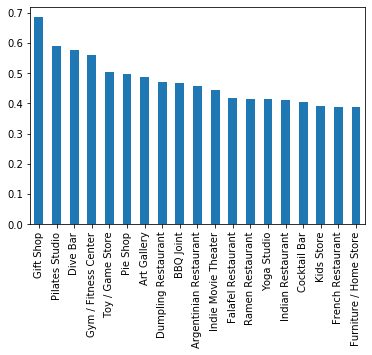

In [188]:
brooklyn_regression.corr()['Income'].sort_values(ascending=False)[1:20].plot(kind='bar')